# MNIST 차원축소

In [80]:
import numpy as np 
import numpy.linalg as lin
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.datasets import fetch_mldata
from scipy import io
import warnings
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline
warnings.filterwarnings('ignore')
np.random.seed(0)

In [81]:
mnist = io.loadmat('mnist-original.mat')

In [82]:
# MNIST 데이터 중 임의추출한 10000개만 사용
X = mnist['data'].T
y = mnist['label'].T

rand_idx = np.random.choice(np.arange(70000), 10000, replace=False)
X = X[rand_idx]
y = y[rand_idx]

In [83]:
print(X.shape, y.shape)

(10000, 784) (10000, 1)


In [84]:
feat_cols = ['pixel'+str(i) for i in range(X.shape[1])]
df = pd.DataFrame(X, columns=feat_cols)
df.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [85]:
df['y'] = y
print('Size of the dataframe: {}'.format(df.shape))

Size of the dataframe: (10000, 785)


<Figure size 432x288 with 0 Axes>

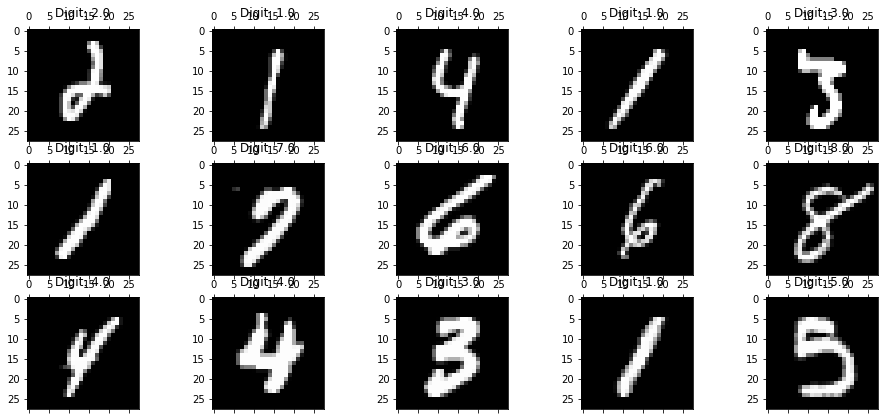

In [86]:
# 데이터 형태 시각화
rndperm = np.random.permutation(df.shape[0])

# Plot the graph
plt.gray()
fig = plt.figure( figsize=(16,7) )
for i in range(0,15):
    ax = fig.add_subplot(3,5,i+1, title="Digit: {}".format(str(df.loc[rndperm[i],'y'])) )
    ax.matshow(df.loc[rndperm[i],feat_cols].values.reshape((28,28)).astype(float))
plt.show()

---

In [87]:
# 8:2로 train-test split
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=11)

## <데이터 생성>
### 원본 데이터

In [88]:
# 정규화
## train data로 fit해야 test set도 train set과 동일하게 선형변환이 되어 
## 주성분이 같은 축으로 된다.
scaler = StandardScaler()
scaler.fit(X_train)
X_train_std = scaler.transform(X_train)
X_test_std  = scaler.transform(X_test)

X_train_std.shape, X_test_std.shape

((8000, 784), (2000, 784))

### PCA 축소 데이터

In [89]:
cov_matrix = np.cov(X_train_std.T)       # 공분산 행렬
eigenval, eigenvec = lin.eig(cov_matrix) # 고유값, 고유벡터

#### 주성분 개수 정하기
##### 방법 1) Kaiser's Rule: 고유값 1 이상의 주성분을 추출

In [90]:
print(len(eigenval[eigenval>1]),'개')

143 개


##### 방법 2) 누적 설명률이 70~80% 이상인 지점

In [91]:
from sklearn.decomposition import PCA

comp_list = [10,30,50,70,90,110,130,150]
for i in comp_list:
    pca_tmp = PCA(n_components = i)
    pca_tmp.fit_transform(df[feat_cols].values)
    print( 'Cumulative explained variation for {} principal components:'.format(i),np.sum(pca_tmp.explained_variance_ratio_))    
    

Cumulative explained variation for 10 principal components: 0.4890289742017373
Cumulative explained variation for 30 principal components: 0.7321502963536698
Cumulative explained variation for 50 principal components: 0.8261030028989147
Cumulative explained variation for 70 principal components: 0.8753967439152919
Cumulative explained variation for 90 principal components: 0.9047709190836748
Cumulative explained variation for 110 principal components: 0.9244224865786944
Cumulative explained variation for 130 principal components: 0.9384774128899709
Cumulative explained variation for 150 principal components: 0.9491338158668312


> 50개의 주성분이 약 82%를 설명하기 때문에 주성분의 개수를 50개로 정한다.

In [92]:
# 방법 2를 채택하여 주성분의 개수를 50개로 정한다.
n_comp = 50

In [93]:
pca = PCA(n_components=n_comp)
pca.fit(X_train_std)
X_train_pca = pca.transform(X_train_std)
X_test_pca  = pca.transform(X_test_std)

X_train_pca.shape, X_test_pca.shape

((8000, 50), (2000, 50))

### LDA 축소 데이터

In [94]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis(n_components=n_comp)
lda.fit(X_train_std, y_train)
X_train_lda = lda.transform(X_train_std)
X_test_lda  = lda.transform(X_test_std)

X_train_lda.shape, X_test_lda.shape

((8000, 9), (2000, 9))

---

## <각 데이터에 분류기 사용>
### 원본 - KNN

In [95]:
from sklearn.neighbors import KNeighborsClassifier
import time

start = time.time()
knn_orig = KNeighborsClassifier(n_neighbors=5)
knn_orig.fit(X_train_std, y_train)
print('Original data 정확도:',knn_orig.score(X_test_std, y_test))
print('걸린 시간:',time.time() - start)

Original data 정확도: 0.913
걸린 시간: 18.032843112945557


### PCA - KNN 

In [96]:
from sklearn.neighbors import KNeighborsClassifier
import time

start = time.time()
knn_pca = KNeighborsClassifier(n_neighbors=5)
knn_pca.fit(X_train_pca, y_train)
print('PCA data 정확도:',knn_pca.score(X_test_pca, y_test))
print('걸린 시간:',time.time() - start)

PCA data 정확도: 0.932
걸린 시간: 1.1549179553985596


### LDA - KNN

In [97]:
from sklearn.neighbors import KNeighborsClassifier
import time

start = time.time()
knn_lda = KNeighborsClassifier(n_neighbors=5)
knn_lda.fit(X_train_lda, y_train)
print('LDA data 정확도:',knn_lda.score(X_test_lda, y_test))
print('걸린 시간:',time.time() - start)

LDA data 정확도: 0.882
걸린 시간: 0.11596798896789551


> 각 데이터에 KNN을 적용한 결과, 차원축소 시 시간이 굉장히 많이 단축되었다. <br/>
**정확도**는 PCA가 가장 높았고, **시간**은 LDA가 가장 짧았다. <br/>


> 일반적으로 LDA의 성능이 높게 나오는 반면, 위 상황에서 PCA의 성능이 더 높은 이유는 <br/>
**숫자의 패턴을 인식**하는 것이 중요한 상황이기 때문일 것이다.

---
### 원본 - RF

In [98]:
from sklearn.ensemble import RandomForestClassifier

start = time.time()
rf_orig = RandomForestClassifier(n_estimators=100, n_jobs=-1, oob_score=True)
rf_orig.fit(X_train_std, y_train)
print('Original data 정확도:',rf_orig.score(X_test_std, y_test))
print('걸린 시간:',time.time() - start)

Original data 정확도: 0.9465
걸린 시간: 1.2325587272644043


### PCA - RF

In [99]:
from sklearn.ensemble import RandomForestClassifier

start = time.time()
rf_pca = RandomForestClassifier(n_estimators=100, n_jobs=-1, oob_score=True)
rf_pca.fit(X_train_pca, y_train)
print('PCA data 정확도:',rf_pca.score(X_test_pca, y_test))
print('걸린 시간:',time.time() - start)

PCA data 정확도: 0.9245
걸린 시간: 1.154118299484253


### LDA - RF

In [100]:
from sklearn.ensemble import RandomForestClassifier

start = time.time()
rf_lda = RandomForestClassifier(n_estimators=100, n_jobs=-1, oob_score=True)
rf_lda.fit(X_train_lda, y_train)
print('LDA data 정확도:',rf_lda.score(X_test_lda, y_test))
print('걸린 시간:',time.time() - start)

LDA data 정확도: 0.8715
걸린 시간: 0.6307759284973145


> 경향성은 KNN을 적용했을 때와 같으나, KNN에 비해 그 차이가 덜 한 편이다.